# 1. Input-output generator

In [1]:
! pip install control


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import control as ctrl
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import pickle

In [2]:
class DataGenerator:
    def __init__(
        self,
        n_config,           # select TF configuration
        sampling_rate=100,  # sampling of the signals
        time_length=9,      # length of the simulation (no leading 0)
        initial_zero=1,     # length in seconds of initial 0
        fixed_period_n=True,
    ):
        # store values
        self.sampling_freq = 1 / sampling_rate
        self.time_length = time_length
        self.initial_zero = initial_zero
        self.fixed_period_n = fixed_period_n

        # select configuration
        s = ctrl.tf('s')
        if n_config == 0:
            self.G = 2**2 / (s**2 + 2*0.3*2*s + 2**2)
        # Update __init__ method for Config 1
        elif n_config == 1:
            self.G1 = 2**2 / (s**2 + 2*0.3*2*s + 2**2)  # First system
            self.G2 = 7**2 / (s**2 + 2*0.6*7*s + 7**2)  # Second system
            self.G = self.G1 + self.G2  # Combined transfer function

        elif n_config == 2:
            self.G = (s**2 - 3*s - 4) / (s**2 + 5*s + 6)
        else:
            raise Exception("Invalid configuration number")

        print(f"TF: {self.G}")

    def get_differential_eq(self, n_config):
        """
        Return the components of the differential equation for the selected transfer function configuration.
        """
        if n_config == 0:
            # Single transfer function
            return {
                'coeffs_y': [1, 1.2, 4],  # Coefficients of [d^2y/dt^2, dy/dt, y]
                'coeffs_u': [4],         # Coefficients of u(t)
            }
        elif n_config == 1:
            # Multiple transfer functions
            return {
                'system_1': {
                    'coeffs_y': [1, 1.2, 4],  # System 1 coefficients
                    'coeffs_u': [4],
                },
                'system_2': {
                    'coeffs_y': [1, 8.4, 49],  # System 2 coefficients
                    'coeffs_u': [49],
                },
            }
        elif n_config == 2:
            # Complex transfer function
            return {
                'coeffs_y': [1, 5, 6],          # Coefficients of [d^2y/dt^2, dy/dt, y]
                'coeffs_u': [1, -3, -4],       # Coefficients of [d^2u/dt^2, du/dt, u]
            }

    def sine_wave_response(self, freq, silent=True):
        return self.response(0, freq, float('NaN'), silent)

    def impulse_response(self, ampl=10, silent=True):
        return self.response(1, float('NaN'), ampl, silent)

    def response(self, type, freq, ampl, silent=True):
        """
        Generate a response (sine wave or impulse) based on the given parameters.
        """
        t_zero = np.arange(0, self.initial_zero, self.sampling_freq)
        t_sim = np.arange(self.initial_zero, self.initial_zero + self.time_length, self.sampling_freq)
    
        if type == 0 and self.fixed_period_n:
            time_period = 1 / freq
            periods_n = self.time_length / time_period
            remaining_period_fraction = periods_n - math.floor(periods_n)
            if not math.isclose(remaining_period_fraction, 0, abs_tol=1e-4):
                missing_part = (1 - remaining_period_fraction) * time_period
                t_addition = np.arange(
                    self.initial_zero + self.time_length,
                    self.initial_zero + self.time_length + missing_part,
                    self.sampling_freq,
                )
                t_sim = np.hstack((t_sim, t_addition))
    
        t = np.hstack((t_zero, t_sim))
    
        leading_zero = np.zeros(len(t_zero), dtype=float)
        if type == 0:
            input_signal = np.sin(2 * np.pi * freq * (t_sim - self.initial_zero))
        elif type == 1:
            input_signal = np.zeros_like(t_sim)
            input_signal[0] = ampl
        else:
            raise Exception("Invalid response type")
        u = np.hstack((leading_zero, input_signal))
    
        # Handle Config 1 (Two Systems)
        if hasattr(self, 'G1') and hasattr(self, 'G2'):
            # Simulate G1 and G2 separately
            t_resp1, y1 = ctrl.forced_response(self.G1, T=t, U=u)
            t_resp2, y2 = ctrl.forced_response(self.G2, T=t, U=u)
            y = y1 + y2  # Total response
        else:
            t_resp, y = ctrl.forced_response(self.G, T=t, U=u)
            y1, y2 = None, None  # Not applicable for Config 0 or Config 2
    
        if not silent:
            plt.figure()
            plt.plot(t, y, label="output (y)")
            if y1 is not None and y2 is not None:
                plt.plot(t, y1, label="output (y1)", linestyle="--")
                plt.plot(t, y2, label="output (y2)", linestyle="-.")
            if type != 1:
                plt.plot(t, u, label="input (u)", linestyle=":")
            plt.legend()
    
        return {'time': t, 'input': u, 'response': y, 'response_1': y1, 'response_2': y2}


# 2. PINN

## 2.1: Define the Physics-Based Loss Function

In [3]:
def physics_loss(t, y_dict, u, config, coeffs_y, coeffs_u):
    """
    Compute the physics loss based on the configuration and differential equations.
    """
    if config == 0:
        # Single equation
        residual = (
            coeffs_y[0] * y_dict['y_ddot'] + coeffs_y[1] * y_dict['y_dot'] + coeffs_y[2] * y_dict['y']
            - coeffs_u[0] * u
        )
        return torch.mean(residual**2)
    
    elif config == 1:
        # Two systems
        # Residual for System 1
        residual_1 = (
            coeffs_y['system_1'][0] * y_dict['y1_ddot']
            + coeffs_y['system_1'][1] * y_dict['y1_dot']
            + coeffs_y['system_1'][2] * y_dict['y1']
            - coeffs_u['system_1'][0] * u
        )
        
        # Residual for System 2
        residual_2 = (
            coeffs_y['system_2'][0] * y_dict['y2_ddot']
            + coeffs_y['system_2'][1] * y_dict['y2_dot']
            + coeffs_y['system_2'][2] * y_dict['y2']
            - coeffs_u['system_2'][0] * u
        )
        
        # Total physics loss
        return torch.mean(residual_1**2) + torch.mean(residual_2**2)
    
    elif config == 2:
        # Complex equation
        residual = (
            coeffs_y[0] * y_dict['y_ddot']
            + coeffs_y[1] * y_dict['y_dot']
            + coeffs_y[2] * y_dict['y']
            - (coeffs_u[0] * y_dict['u_ddot'] + coeffs_u[1] * y_dict['u_dot'] + coeffs_u[2] * u)
        )
        return torch.mean(residual**2)
    
    else:
        raise ValueError("Invalid configuration")
        
def data_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true)**2)

def boundary_loss(config, y0_pred, y0_true, y0_dot_pred, y0_dot_true):
    if config == 0 or config == 2:
        return torch.mean((y0_pred - y0_true)**2) + torch.mean((y0_dot_pred - y0_dot_true)**2)
    
    elif config == 1:
        return (
            torch.mean((y0_pred['system_1'] - y0_true['system_1'])**2)
            + torch.mean((y0_dot_pred['system_1'] - y0_dot_true['system_1'])**2)
            + torch.mean((y0_pred['system_2'] - y0_true['system_2'])**2)
            + torch.mean((y0_dot_pred['system_2'] - y0_dot_true['system_2'])**2)
        )
    else:
        raise ValueError("Invalid configuration")

def total_loss(
    t,
    y_dict,
    u,
    config,
    coeffs_y,
    coeffs_u,
    y_true=None,
    y0_pred=None,
    y0_true=None,
    y0_dot_pred=None,
    y0_dot_true=None,
    lambdas=(1.0, 1.0, 1.0),
):
    """
    Compute the total loss as a weighted sum of physics, data, and boundary losses.
    """
    lambda1, lambda2, lambda3 = lambdas

    # Physics loss
    L_physics = physics_loss(t, y_dict, u, config, coeffs_y, coeffs_u)

    # Data loss (if true data is provided)
    if config == 1:
        # For Config 1, compute data loss for y1 and y2 separately
        L_data = (
            data_loss(y_dict['y1'], y_true['y1'])
            + data_loss(y_dict['y2'], y_true['y2'])
            if y_true is not None
            else 0.0
        )
    else:
        # For Config 0 and Config 2, use 'y'
        L_data = data_loss(y_dict['y'], y_true) if y_true is not None else 0.0

    # Boundary loss (if initial conditions are provided)
    L_boundary = (
        boundary_loss(config, y0_pred, y0_true, y0_dot_pred, y0_dot_true)
        if y0_true is not None
        else 0.0
    )

    return lambda1 * L_physics + lambda2 * L_data + lambda3 * L_boundary

## 2.2: Build the Neural Network

In [4]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 2.3 Dataset

In [5]:
min_f, max_f, step_f = 1, 10, 0.05
train_freq = np.arange(min_f, max_f + step_f, step_f)
val_freq = np.arange(min_f + step_f / 2, max_f + step_f, step_f * 4)
test_freq = np.arange(min_f + 3 * step_f / 2, max_f + step_f, step_f * 4)

In [50]:
def create_pinn_dataset(data_generator, frequencies, label):
    dataset = []
    for freq in frequencies:
        data = data_generator.sine_wave_response(freq)
        t = data['time']
        u = data['input']
        y = data['response']
        
        # For Config 1, include y1 and y2
        y1 = data.get('response_1', None)
        y2 = data.get('response_2', None)

        # Compute derivatives
        y_dot = np.gradient(y, t)
        y_ddot = np.gradient(y_dot, t)
        u_dot = np.gradient(u, t)
        u_ddot = np.gradient(u_dot, t)

        # Compute derivatives for y1 and y2 if available
        y1_dot = np.gradient(y1, t) if y1 is not None else None
        y1_ddot = np.gradient(y1_dot, t) if y1_dot is not None else None
        y2_dot = np.gradient(y2, t) if y2 is not None else None
        y2_ddot = np.gradient(y2_dot, t) if y2_dot is not None else None

        # Combine into a single dataset
        dataset_entry = {
            't': t,
            'u': u,
            'y': y,
            'y_dot': y_dot,
            'y_ddot': y_ddot,
            'u_dot': u_dot,
            'u_ddot': u_ddot,
        }

        # Add y1 and y2 if available
        if y1 is not None and y2 is not None:
            dataset_entry.update({
                'y1': y1,
                'y1_dot': y1_dot,
                'y1_ddot': y1_ddot,
                'y2': y2,
                'y2_dot': y2_dot,
                'y2_ddot': y2_ddot,
            })

        dataset.append(dataset_entry)
    #print(f"{label} dataset created with {len(dataset)} samples.")
    return dataset

In [51]:
def create_and_save_pinn_datasets(configs, train_freq, val_freq, test_freq):
    for config in configs:
        # Initialize DataGenerator for each configuration
        data_generator = DataGenerator(config, sampling_rate=100, time_length=10, initial_zero=2)
        
        # Generate datasets
        train_dataset = create_pinn_dataset(data_generator, train_freq, f"Train (Config {config})")
        val_dataset = create_pinn_dataset(data_generator, val_freq, f"Validation (Config {config})")
        test_dataset = create_pinn_dataset(data_generator, test_freq, f"Test (Config {config})")
        
        # Save datasets to pickle files
        filename_prefix = f"pinn_config{config}"
        with open(f"{filename_prefix}_train.pkl", "wb") as f:
            pickle.dump(train_dataset, f)
        with open(f"{filename_prefix}_val.pkl", "wb") as f:
            pickle.dump(val_dataset, f)
        with open(f"{filename_prefix}_test.pkl", "wb") as f:
            pickle.dump(test_dataset, f)

        #print(f"Datasets for Config {config} saved as {filename_prefix}_*.pkl")

# Frequency sets
min_f, max_f, step_f = 1, 10, 0.05
train_freq = np.arange(min_f, max_f + step_f, step_f)
val_freq = np.arange(min_f + step_f / 2, max_f + step_f, step_f * 4)
test_freq = np.arange(min_f + 3 * step_f / 2, max_f + step_f, step_f * 4)

# Create datasets for configurations 0, 1, 2
create_and_save_pinn_datasets([0, 1, 2], train_freq, val_freq, test_freq)

TF: <TransferFunction>: sys[2854]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4

TF: <TransferFunction>: sys[3147]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         53 s^2 + 92.4 s + 392
----------------------------------------
s^4 + 9.6 s^3 + 63.08 s^2 + 92.4 s + 196

TF: <TransferFunction>: sys[3709]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s^2 - 3 s - 4
-------------
s^2 + 5 s + 6



In [5]:
# Function to load a dataset
def load_pinn_dataset(config):
    filename_prefix = f"pinn_config{config}"
    with open(f"{filename_prefix}_train.pkl", "rb") as f:
        train_dataset = pickle.load(f)
    with open(f"{filename_prefix}_val.pkl", "rb") as f:
        val_dataset = pickle.load(f)
    with open(f"{filename_prefix}_test.pkl", "rb") as f:
        test_dataset = pickle.load(f)
    return train_dataset, val_dataset, test_dataset

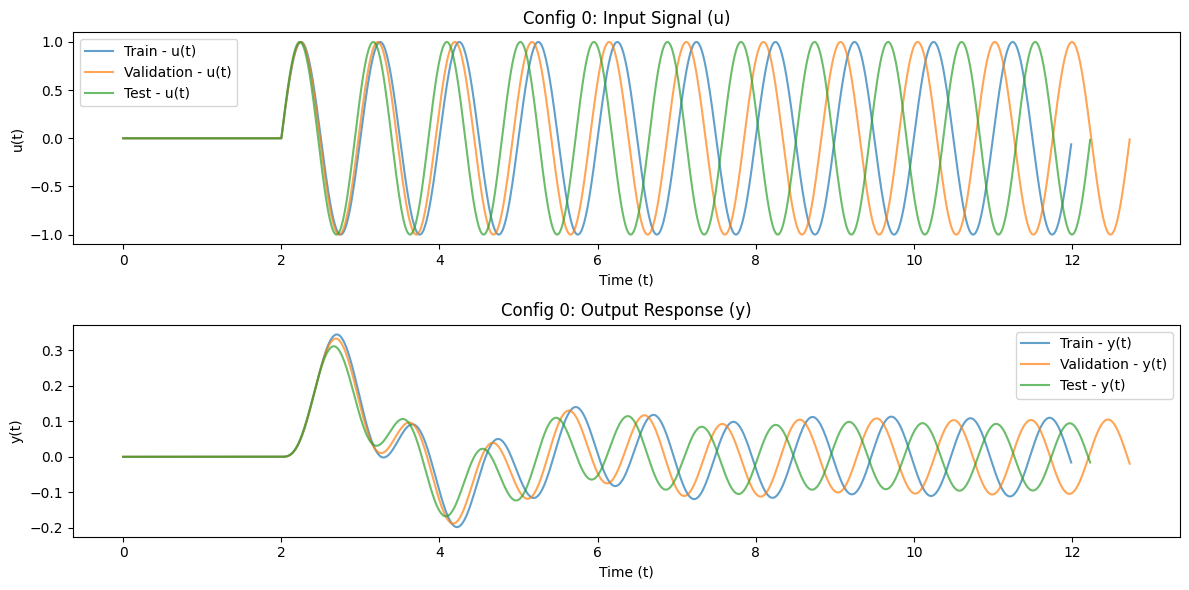

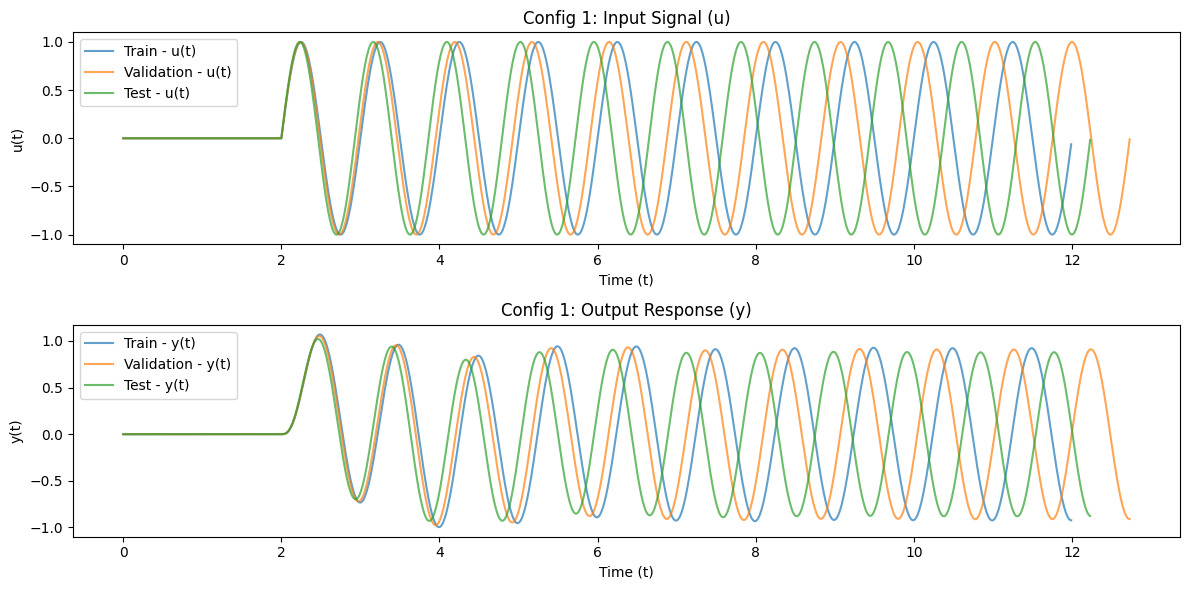

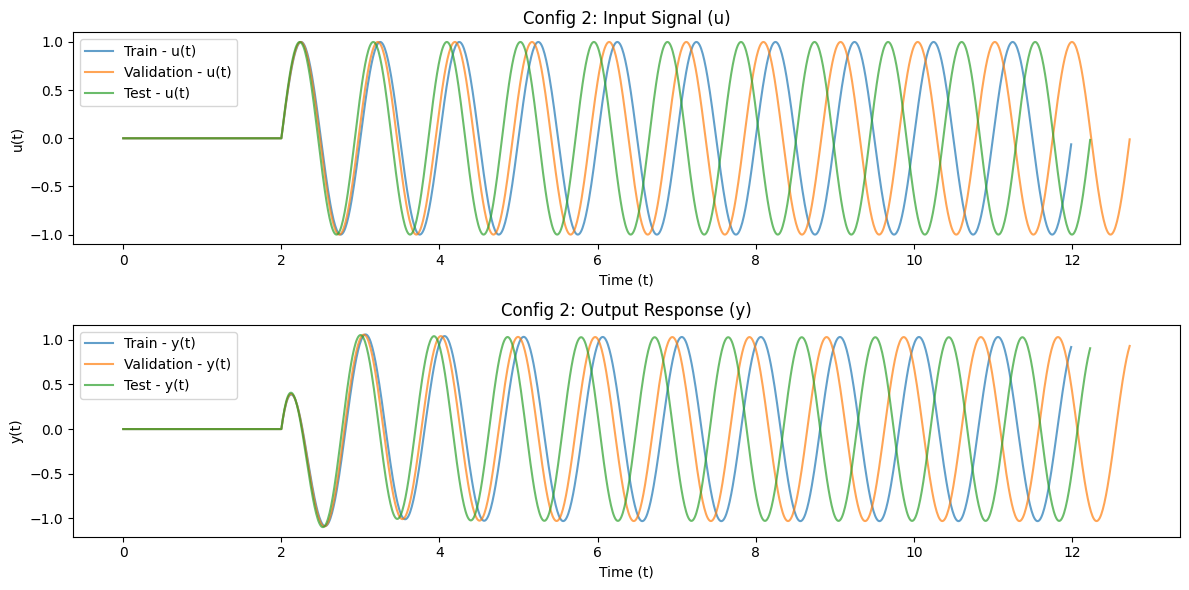

In [11]:
def plot_sample_from_each_config(configs):
    for config in configs:
        # File names
        filename_prefix = f"pinn_config{config}"
        train_file = f"{filename_prefix}_train.pkl"
        val_file = f"{filename_prefix}_val.pkl"
        test_file = f"{filename_prefix}_test.pkl"
        
        # Load datasets
        with open(train_file, "rb") as f:
            train_dataset = pickle.load(f)
        with open(val_file, "rb") as f:
            val_dataset = pickle.load(f)
        with open(test_file, "rb") as f:
            test_dataset = pickle.load(f)
        
        # Extract a sample
        train_sample = train_dataset[0]
        val_sample = val_dataset[0]
        test_sample = test_dataset[0]
        
        # Plot the data
        plt.figure(figsize=(12, 6))
        
        # Plot 'u' vs. 't' (input signal)
        plt.subplot(2, 1, 1)
        plt.plot(train_sample['t'], train_sample['u'], label='Train - u(t)', alpha=0.7)
        plt.plot(val_sample['t'], val_sample['u'], label='Validation - u(t)', alpha=0.7)
        plt.plot(test_sample['t'], test_sample['u'], label='Test - u(t)', alpha=0.7)
        plt.title(f'Config {config}: Input Signal (u)')
        plt.xlabel('Time (t)')
        plt.ylabel('u(t)')
        plt.legend()
        
        # Plot 'y' vs. 't' (output response)
        plt.subplot(2, 1, 2)
        plt.plot(train_sample['t'], train_sample['y'], label='Train - y(t)', alpha=0.7)
        plt.plot(val_sample['t'], val_sample['y'], label='Validation - y(t)', alpha=0.7)
        plt.plot(test_sample['t'], test_sample['y'], label='Test - y(t)', alpha=0.7)
        plt.title(f'Config {config}: Output Response (y)')
        plt.xlabel('Time (t)')
        plt.ylabel('y(t)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function with your configurations
plot_sample_from_each_config([0, 1, 2])

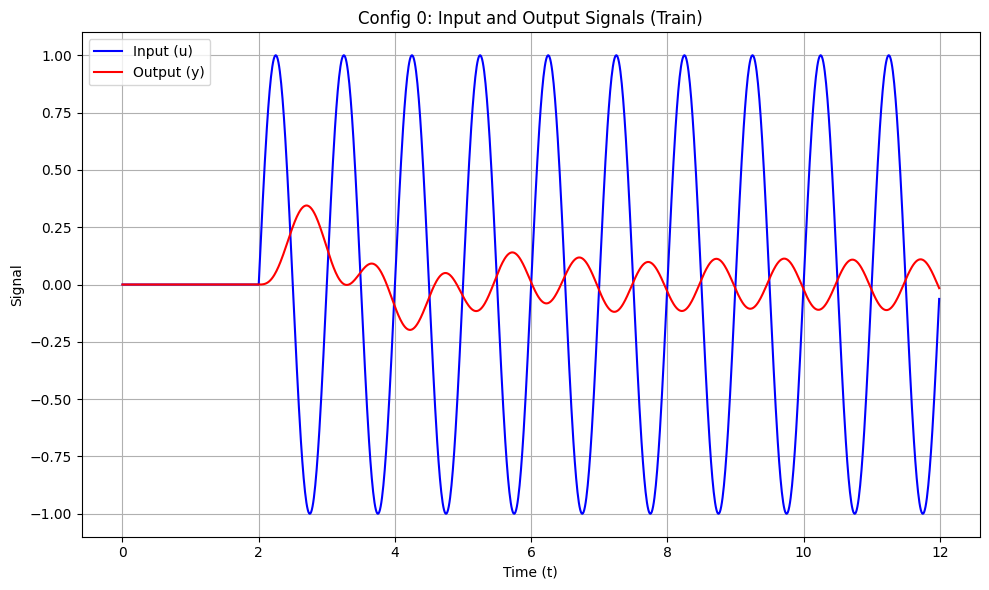

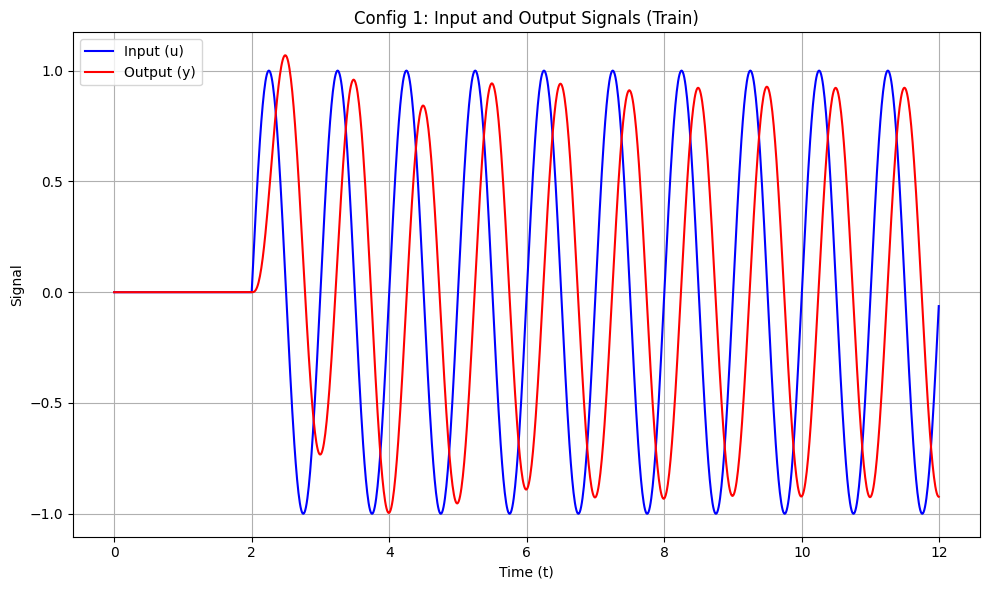

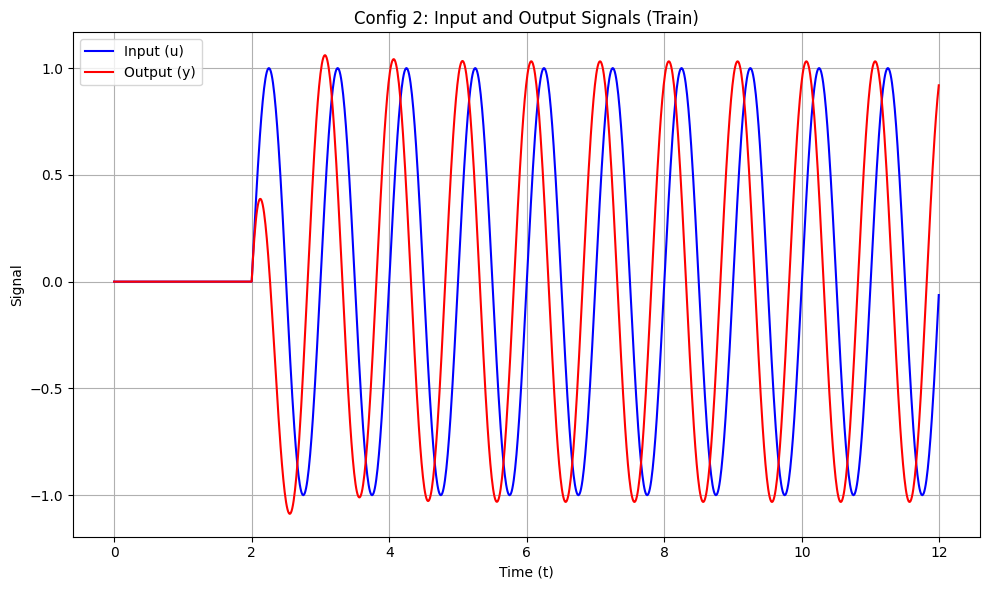

In [19]:
def plot_train_input_output(configs):
    for config in configs:
        # File names
        filename_prefix = f"pinn_config{config}"
        train_file = f"{filename_prefix}_train.pkl"
        
        # Load train dataset
        with open(train_file, "rb") as f:
            train_dataset = pickle.load(f)
        
        # Extract a sample
        train_sample = train_dataset[0]
        
        # Plot the data
        plt.figure(figsize=(10, 6))
        
        # Plot input signal 'u' and output response 'y' on the same graph
        plt.plot(train_sample['t'], train_sample['u'], label='Input (u)', color='blue', linestyle='-')
        plt.plot(train_sample['t'], train_sample['y'], label='Output (y)', color='red', linestyle='-')
        plt.title(f'Config {config}: Input and Output Signals (Train)')
        plt.xlabel('Time (t)')
        plt.ylabel('Signal')
        plt.legend()
        plt.grid(True)
        
        # Show plot
        plt.tight_layout()
        plt.show()

# Call the function with your configurations
plot_train_input_output([0, 1, 2])

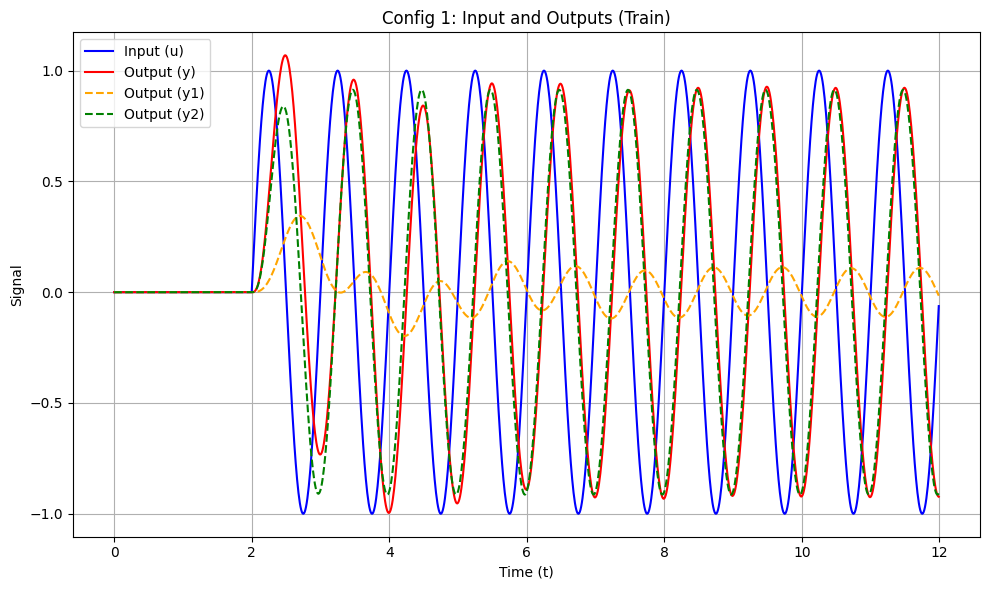

In [18]:
def plot_config1_input_and_outputs_styled():
    # File name for Config 1
    filename_prefix = "pinn_config1"
    train_file = f"{filename_prefix}_train.pkl"
    
    # Load train dataset
    with open(train_file, "rb") as f:
        train_dataset = pickle.load(f)
    
    # Extract a sample
    train_sample = train_dataset[0]
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    
    # Plot input signal 'u' in continuous blue
    plt.plot(train_sample['t'], train_sample['u'], label='Input (u)', color='blue', linestyle='-')
    
    # Plot output signal 'y' in continuous orange
    plt.plot(train_sample['t'], train_sample['y'], label='Output (y)', color='red', linestyle='-')
    
    # Plot output signal 'y1' in dashed red
    plt.plot(train_sample['t'], train_sample['y1'], label='Output (y1)', color='orange', linestyle='--')
    
    # Plot output signal 'y2' in dashed yellow
    plt.plot(train_sample['t'], train_sample['y2'], label='Output (y2)', color='green', linestyle='--')
    
    # Formatting the plot
    plt.title('Config 1: Input and Outputs (Train)')
    plt.xlabel('Time (t)')
    plt.ylabel('Signal')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function to plot Config 1
plot_config1_input_and_outputs_styled()

# 3. Training

In [59]:
# Training loop for all configurations
configs = [0, 1, 2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize loss history
loss_history = {config: [] for config in configs}

for config in configs:
    print(f"\n=== Training for Config {config} ===")

    # Load dataset
    train_dataset, val_dataset, test_dataset = load_pinn_dataset(config)

    # Initialize DataGenerator and retrieve coefficients
    data_generator = DataGenerator(config, sampling_rate=100, time_length=10, initial_zero=2)
    coefficients = data_generator.get_differential_eq(config)

    # Initialize PINN
    input_dim = 2  # [t, u]
    output_dim = 2 if config == 1 else 1  # [y1, y2] for Config 1, otherwise [y]
    pinn = PINN(input_dim=input_dim, output_dim=output_dim, hidden_size=50, num_layers=4).to(device)

    optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

    best_loss = float('inf')
    best_model_state = None

    # Define the parameters that rely on the configuration

    if config == 0:
        num_epochs = 10000
        lambdas = (0.9, 0.0, 0.1)
        coeffs_y = coefficients['coeffs_y']
        coeffs_u = coefficients['coeffs_u']

    elif config == 1:
        num_epochs = 30000
        lambdas = (0.75, 0.15, 0.1)
        coeffs_y = {
            'system_1': coefficients['system_1']['coeffs_y'],
            'system_2': coefficients['system_2']['coeffs_y'],
        }
        coeffs_u = {
            'system_1': coefficients['system_1']['coeffs_u'],
            'system_2': coefficients['system_2']['coeffs_u'],
        }
    elif config == 2:
        num_epochs = 20000
        lambdas = (0.9, 0, 0.1)
        coeffs_y = coefficients['coeffs_y']
        coeffs_u = coefficients['coeffs_u']

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Fetch a sample from the training dataset
        sample = train_dataset[0]
        t = torch.tensor(sample['t'], requires_grad=True, dtype=torch.float32).to(device)
        u = torch.tensor(sample['u'], dtype=torch.float32).to(device)

        if config == 1:
            # For Config 1, y_true contains y1 and y2
            y_true = {
                'y1': torch.tensor(sample['y1'], dtype=torch.float32).to(device),
                'y2': torch.tensor(sample['y2'], dtype=torch.float32).to(device),
            }
        else:
            # For Config 0 and Config 2, y_true contains y
            y_true = torch.tensor(sample['y'], dtype=torch.float32).to(device)

        # Forward pass
        inputs = torch.cat((t.unsqueeze(1), u.unsqueeze(1)), dim=1)
        outputs = pinn(inputs)

        # Prepare y_dict
        if config == 0:
            y_dict = {
                'y': outputs[:, 0],
                'y_dot': torch.tensor(sample['y_dot'], dtype=torch.float32).to(device),
                'y_ddot': torch.tensor(sample['y_ddot'], dtype=torch.float32).to(device),
            }

        elif config == 1:
            y_dict = {
                'y1': outputs[:, 0],
                'y1_dot': torch.tensor(sample['y1_dot'], dtype=torch.float32).to(device),
                'y1_ddot': torch.tensor(sample['y1_ddot'], dtype=torch.float32).to(device),
                'y2': outputs[:, 1],
                'y2_dot': torch.tensor(sample['y2_dot'], dtype=torch.float32).to(device),
                'y2_ddot': torch.tensor(sample['y2_ddot'], dtype=torch.float32).to(device),
            }
        elif config == 2:
            y_dict = {
                'y': outputs[:, 0],
                'y_dot': torch.tensor(sample['y_dot'], dtype=torch.float32).to(device),
                'y_ddot': torch.tensor(sample['y_ddot'], dtype=torch.float32).to(device),
                'u_dot': torch.tensor(sample['u_dot'], dtype=torch.float32).to(device),
                'u_ddot': torch.tensor(sample['u_ddot'], dtype=torch.float32).to(device),
            }

        # Compute Total Loss
        total_loss_value = total_loss(
            t=t,
            y_dict=y_dict,
            u=u,
            config=config,
            coeffs_y=coeffs_y,
            coeffs_u=coeffs_u,
            y_true=y_true,
            lambdas=lambdas,
        )

        # Backpropagation
        total_loss_value.backward()
        optimizer.step()

        # Track the best model
        if total_loss_value.item() < best_loss:
            best_loss = total_loss_value.item()
            best_model_state = pinn.state_dict()

        # Log the loss value
        loss_history[config].append(total_loss_value.item())

        # Logging
        if epoch % 100 == 0:
            print(f"Config {config}, Epoch {epoch}, Total Loss: {total_loss_value.item():.6f}")

    # Save the best model for the current configuration
    torch.save(best_model_state, f"pinn_config{config}_best_model.pth")
    print(f"Best model for Config {config} saved with loss: {best_loss:.6f}")


=== Training for Config 0 ===
TF: <TransferFunction>: sys[4093]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4

Config 0, Epoch 0, Total Loss: 0.152384
Config 0, Epoch 100, Total Loss: 0.045999
Config 0, Epoch 200, Total Loss: 0.039677
Config 0, Epoch 300, Total Loss: 0.045417
Config 0, Epoch 400, Total Loss: 0.027423
Config 0, Epoch 500, Total Loss: 0.023263
Config 0, Epoch 600, Total Loss: 0.019695
Config 0, Epoch 700, Total Loss: 0.021515
Config 0, Epoch 800, Total Loss: 0.014456
Config 0, Epoch 900, Total Loss: 0.012675
Config 0, Epoch 1000, Total Loss: 0.012632
Config 0, Epoch 1100, Total Loss: 0.011236
Config 0, Epoch 1200, Total Loss: 0.010447
Config 0, Epoch 1300, Total Loss: 0.009760
Config 0, Epoch 1400, Total Loss: 0.009795
Config 0, Epoch 1500, Total Loss: 0.009098
Config 0, Epoch 1600, Total Loss: 0.008641
Config 0, Epoch 1700, Total Loss: 0.008218
Config 0, Epoch 1800, Total Loss: 0.025111
Config 0, Epoch 1900, Total Loss: 0.007806


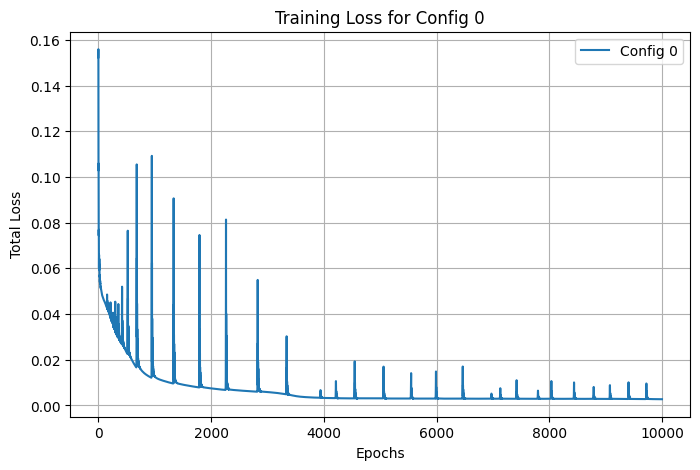

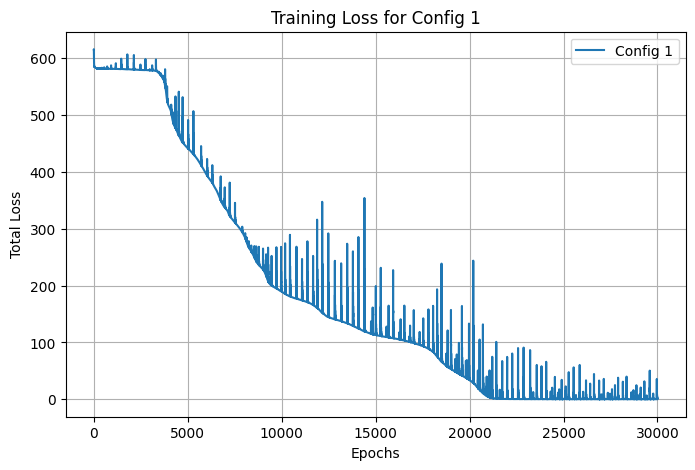

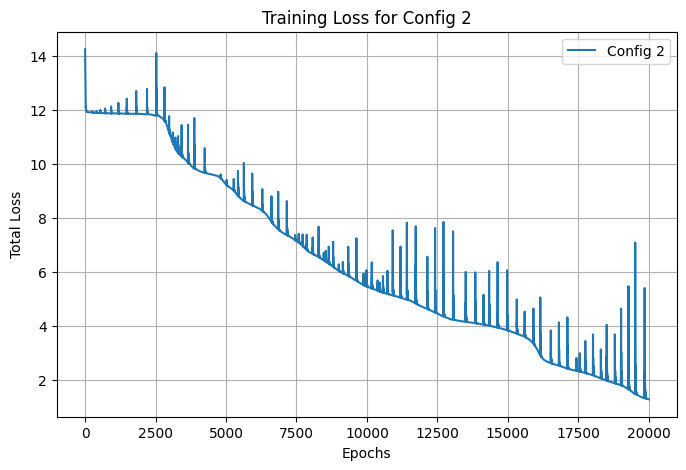

In [60]:
# Plot Training Loss for Each Configuration Separately
for config, losses in loss_history.items():
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label=f"Config {config}")
    plt.title(f"Training Loss for Config {config}")
    plt.xlabel("Epochs")
    plt.ylabel("Total Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. Evaluation and Visualization    


=== Evaluating Model for Config 0 ===


C:\Users\ivanf\AppData\Local\Temp\ipykernel_2816\3578870312.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn.load_state_dict(torch.load(model_path))


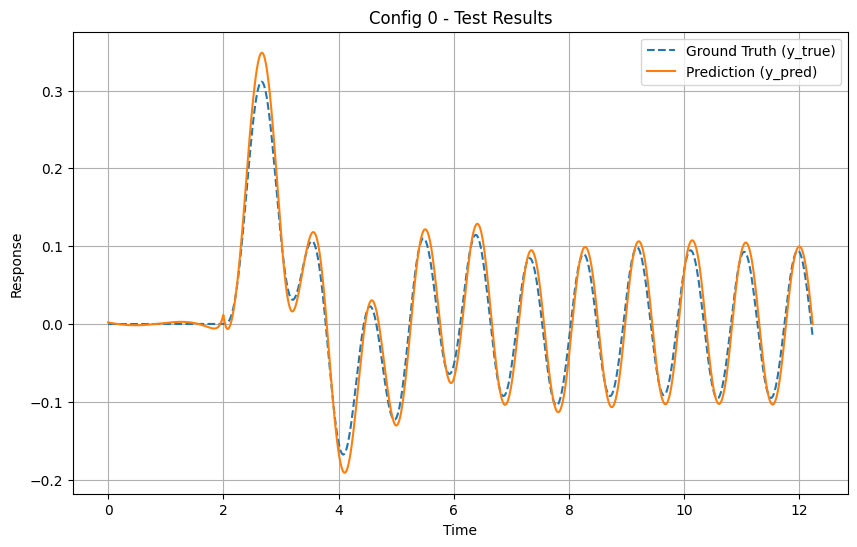

Config 0 - Mean Squared Error: 0.000243

=== Evaluating Model for Config 1 ===


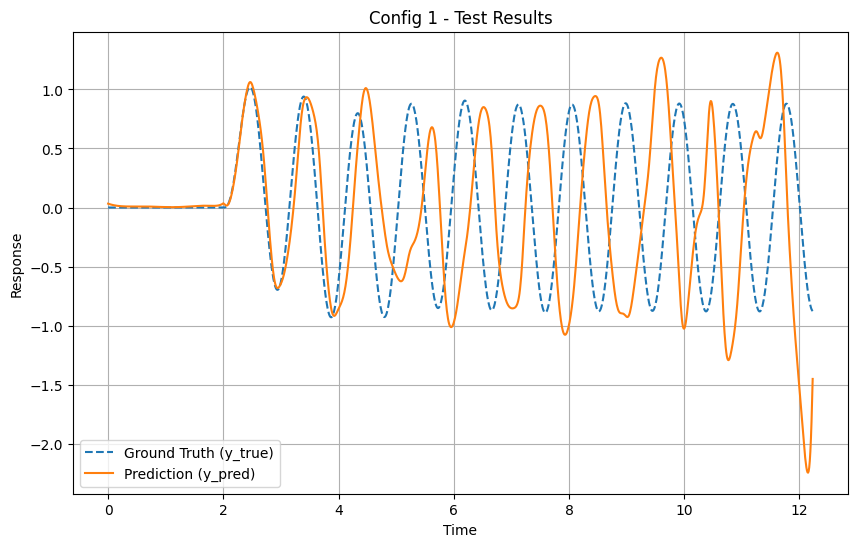

Config 1 - Mean Squared Error: 0.903361

=== Evaluating Model for Config 2 ===


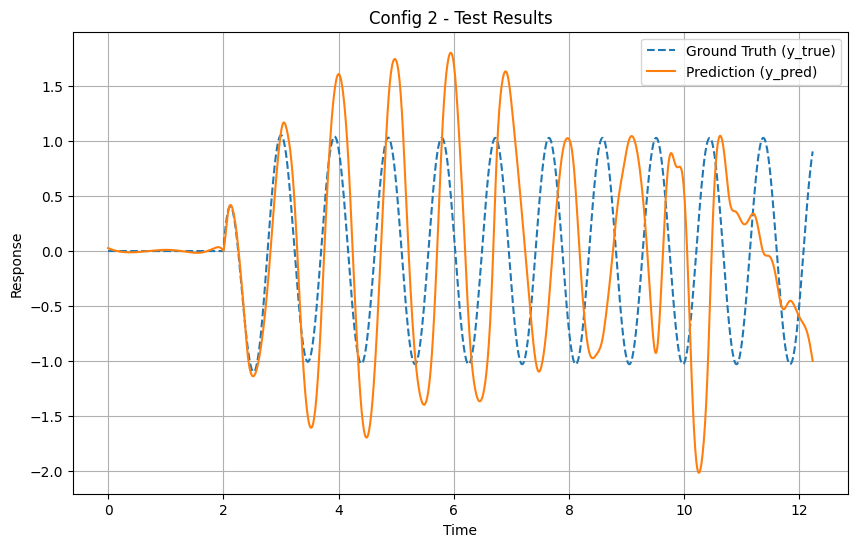

Config 2 - Mean Squared Error: 0.908485


In [7]:
# Evaluation loop for all configurations
configs = [0, 1, 2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for config in configs:
    print(f"\n=== Evaluating Model for Config {config} ===")

    # Load the best model
    model_path = f"pinn_config{config}_best_model.pth"
    input_dim = 2  # [t, u]
    output_dim = 2 if config == 1 else 1  # [y1, y2] for Config 1, otherwise [y]
    pinn = PINN(input_dim=input_dim, output_dim=output_dim, hidden_size=50, num_layers=4).to(device)
    pinn.load_state_dict(torch.load(model_path))
    pinn.eval()

    # Load the test dataset
    _, _, test_dataset = load_pinn_dataset(config)

    # Fetch a sample from the test dataset
    sample = test_dataset[0]  # You can loop through the dataset if needed
    t = torch.tensor(sample['t'], requires_grad=True, dtype=torch.float32).to(device)
    u = torch.tensor(sample['u'], dtype=torch.float32).to(device)

    # Forward pass
    inputs = torch.cat((t.unsqueeze(1), u.unsqueeze(1)), dim=1)
    outputs = pinn(inputs)

    # For Config 1, split predictions into y1 and y2
    if config == 1:
        y1_pred = outputs[:, 0].detach().cpu().numpy()
        y2_pred = outputs[:, 1].detach().cpu().numpy()
        y1_true = sample['y1']
        y2_true = sample['y2']
        y_pred = y1_pred + y2_pred
        y_true = y1_true + y2_true
    else:
        y_pred = outputs[:, 0].detach().cpu().numpy()
        y_true = sample['y']

    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.plot(sample['t'], y_true, label="Ground Truth (y_true)", linestyle="--")
    plt.plot(sample['t'], y_pred, label="Prediction (y_pred)", linestyle="-")
    plt.title(f"Config {config} - Test Results")
    plt.xlabel("Time")
    plt.ylabel("Response")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print evaluation summary
    mse = np.mean((y_pred - y_true)**2)
    print(f"Config {config} - Mean Squared Error: {mse:.6f}")

In [8]:
print(f"\nNumber of parameters: {sum(p.numel() for p in pinn.parameters() if p.requires_grad)}")


Number of parameters: 7851



=== Evaluating Model for Config 0 with Impulse Input ===
TF: <TransferFunction>: sys[4142]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4



C:\Users\ivanf\AppData\Local\Temp\ipykernel_13032\3163432609.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn.load_state_dict(torch.load(model_path))


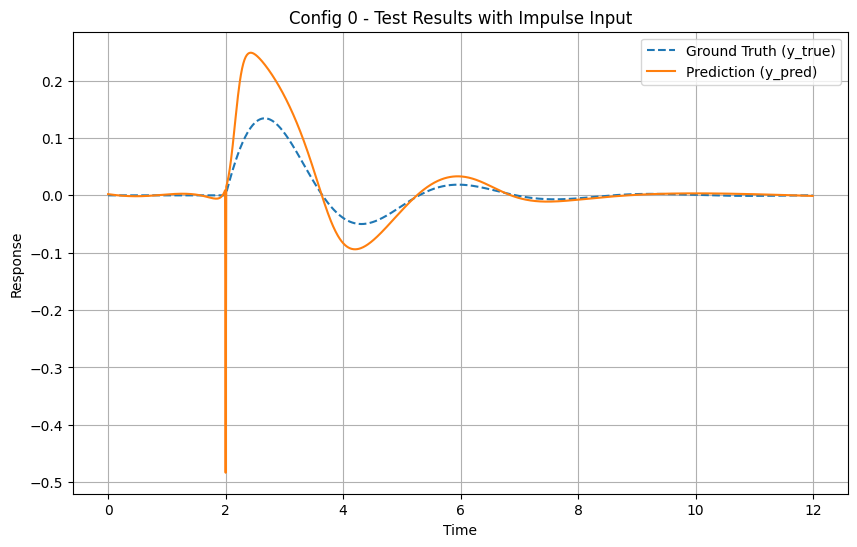

Config 0 - Mean Squared Error (Impulse Input): 0.001200

=== Evaluating Model for Config 1 with Impulse Input ===
TF: <TransferFunction>: sys[4164]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         53 s^2 + 92.4 s + 392
----------------------------------------
s^4 + 9.6 s^3 + 63.08 s^2 + 92.4 s + 196



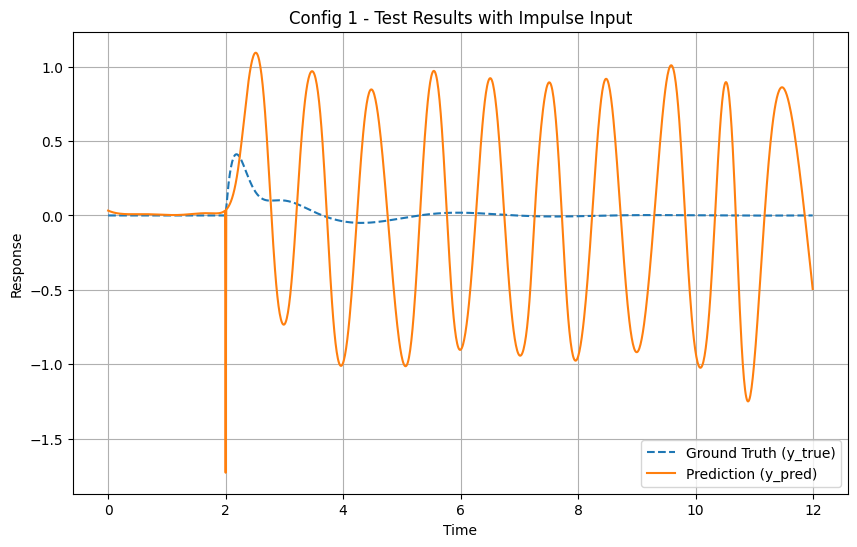

Config 1 - Mean Squared Error (Impulse Input): 0.376699

=== Evaluating Model for Config 2 with Impulse Input ===
TF: <TransferFunction>: sys[4184]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s^2 - 3 s - 4
-------------
s^2 + 5 s + 6



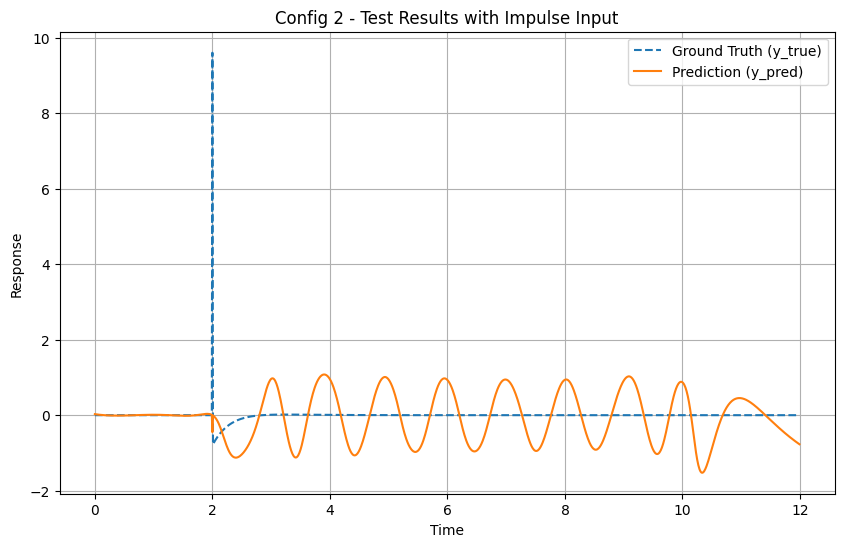

Config 2 - Mean Squared Error (Impulse Input): 0.485851


In [62]:
# Evaluation loop for all configurations with impulse input
configs = [0, 1, 2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for config in configs:
    print(f"\n=== Evaluating Model for Config {config} with Impulse Input ===")

    # Load the best model
    model_path = f"pinn_config{config}_best_model.pth"
    input_dim = 2  # [t, u]
    output_dim = 2 if config == 1 else 1  # [y1, y2] for Config 1, otherwise [y]
    pinn = PINN(input_dim=input_dim, output_dim=output_dim, hidden_size=50, num_layers=4).to(device)
    pinn.load_state_dict(torch.load(model_path))
    pinn.eval()

    # Generate impulse input using DataGenerator
    data_generator = DataGenerator(config, sampling_rate=100, time_length=10, initial_zero=2)
    impulse_data = data_generator.impulse_response(ampl=10, silent=True)
    t = torch.tensor(impulse_data['time'], requires_grad=True, dtype=torch.float32).to(device)
    u = torch.tensor(impulse_data['input'], dtype=torch.float32).to(device)

    # Forward pass
    inputs = torch.cat((t.unsqueeze(1), u.unsqueeze(1)), dim=1)
    outputs = pinn(inputs)

    # For Config 1, split predictions into y1 and y2
    if config == 1:
        y1_pred = outputs[:, 0].detach().cpu().numpy()
        y2_pred = outputs[:, 1].detach().cpu().numpy()
        y1_true = impulse_data['response_1']
        y2_true = impulse_data['response_2']
        y_pred = y1_pred + y2_pred
        y_true = y1_true + y2_true
    else:
        y_pred = outputs[:, 0].detach().cpu().numpy()
        y_true = impulse_data['response']

    # Plot predictions vs. ground truth
    plt.figure(figsize=(10, 6))
    plt.plot(impulse_data['time'], y_true, label="Ground Truth (y_true)", linestyle="--")
    plt.plot(impulse_data['time'], y_pred, label="Prediction (y_pred)", linestyle="-")
    plt.title(f"Config {config} - Test Results with Impulse Input")
    plt.xlabel("Time")
    plt.ylabel("Response")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print evaluation summary
    mse = np.mean((y_pred - y_true)**2)
    print(f"Config {config} - Mean Squared Error (Impulse Input): {mse:.6f}")
